<a href="https://colab.research.google.com/github/ameenattar92/Cardiovascular-Risk-Prediction/blob/main/Pradip_Cardiovascular_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset is from an ongoing cardiovascular study on residents of the town of Framingham,
Massachusetts.

The classification goal is to predict whether the patient has a 10-year risk of
future coronary heart disease (CHD). 

The dataset provides the patients’ information. It includes
over 4,000 records and 15 attributes.
Variables
Each attribute is a potential risk factor. There are both demographic, behavioral, and medical risk
factors.

# **Data Description**
### **Demographic:**
* Sex: male or female("M" or "F")
* Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

### **Behavioral**
* is_smoking: whether or not the patient is a current smoker ("YES" or "NO")
* Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be
considered continuous as one can have any number of cigarettes, even half a cigarette.)

### **Medical( history)**
* BP Meds: whether or not the patient was on blood pressure medication (Nominal)
* Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
* Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
* Diabetes: whether or not the patient had diabetes (Nominal)
Medical(current)
* Tot Chol: total cholesterol level (Continuous)
* Sys BP: systolic blood pressure (Continuous)
* Dia BP: diastolic blood pressure (Continuous)
* BMI: Body Mass Index (Continuous)
* Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in
fact discrete, yet are considered continuous because of large number of possible values.)
* Glucose: glucose level (Continuous)
Predict variable (desired target)
* 10-year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”) -
DV

In [102]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


%matplotlib inline

In [25]:
path = '/content/drive/MyDrive/Capstone Project/Cardiovascular Risk Prediction - Pradip Solanki/data/data_cardiovascular_risk.csv'
df = pd.read_csv(path)

In [26]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [28]:
# fill value with mode for qualitative values
df['sex'].fillna(df['sex'].mode()[0], inplace=True)
df['is_smoking'].fillna(df['is_smoking'].mode()[0], inplace=True)
df['BPMeds'].fillna(df['BPMeds'].mode()[0], inplace=True)
# fill values with mean for quantitative values
df.fillna(df.mean(axis=0), inplace=True)

In [29]:
df.isnull().sum()

id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

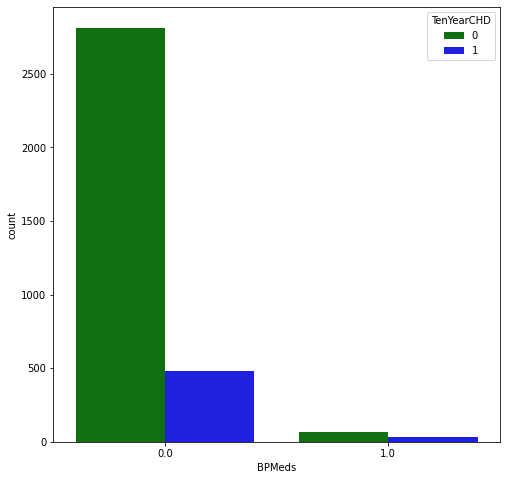

In [30]:
my_palette = {0 : 'Green' , 1 : 'Blue'}
plt.figure(figsize = (8,8))
sns.countplot(x = df['BPMeds'], hue = df['TenYearCHD'], palette = my_palette)
plt.show()

In [31]:
df['sex'] = df['sex'].apply(lambda x: 1 if x=='M' else 0)
df['is_smoking'] = df['is_smoking'].apply(lambda x: 1 if x=='YES' else 0)

In [33]:
df.drop(columns=['id'],inplace=True)

In [34]:
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.794964,90.0,80.0,1
1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.0,0
2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.0,0
3,50,1.0,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.0,1
4,64,1.0,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.0,0


## **Knn**

Let's first build baseline model with knn.
We have 16 variables so it will be 15 dimension space for knn which is large and computationaly expensive so, we apply principle component analysis to reduce dimentions.

In [55]:
X = df.drop(columns=['TenYearCHD']).values
Y = df['TenYearCHD'].values

In [37]:
X

array([[64.        ,  2.        ,  0.        , ..., 25.79496445,
        90.        , 80.        ],
       [36.        ,  4.        ,  1.        , ..., 29.77      ,
        72.        , 75.        ],
       [46.        ,  1.        ,  0.        , ..., 20.35      ,
        88.        , 94.        ],
       ...,
       [44.        ,  3.        ,  1.        , ..., 28.92      ,
        73.        , 72.        ],
       [60.        ,  1.        ,  1.        , ..., 23.01      ,
        80.        , 85.        ],
       [54.        ,  3.        ,  0.        , ..., 29.88      ,
        79.        , 92.        ]])

In [50]:
pca = PCA(n_components=5)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [51]:
X_pca = pca.transform(X)

In [52]:
X_pca

array([[-12.36217972,  16.37840642, -12.2062365 ,   1.93013154,
         13.16744469],
       [-20.00348758,  28.94530634, -28.50496351,  -6.82218042,
         -1.13977723],
       [ 10.36217786, -10.37308327,  22.00998574,   9.22828884,
          9.67806722],
       ...,
       [118.90473446,   9.49511865, -27.54634673,  -4.49696443,
         -3.74539831],
       [-38.3693405 ,  42.66917362, -24.17663547,  -5.48088975,
          4.81219821],
       [ 49.59480631,  -8.83817924,  16.19215891,  -5.55134504,
          8.63026006]])

In [53]:
pca.explained_variance_ratio_

array([0.578301  , 0.17517898, 0.13577788, 0.04307383, 0.03471649])

We can see that after 3rd component explained variance ratio decrease drastically so, we will use first 5 components for knn model.
Now lets find out optimal number of neighbours.

In [59]:
# perform split 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

In [60]:
print(X.shape, Y.shape)
print(X_train.shape)
print(X_test.shape)

(3390, 15) (3390,)
(2542, 15)
(848, 15)


In [65]:
# calculate accuracy score for first 10 neighbors
# Setup arrays to store training and test accuracies
neighbors = 10
train_accuracy = np.empty(neighbors)
test_accuracy = np.empty(neighbors)

for i in range(1, neighbors + 1):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=i)
    # Fit the model
    knn.fit(X_train, Y_train)
    # Compute accuracy on the training set
    train_accuracy[i - 1] = knn.score(X_train, Y_train)
    # Compute accuracy on the test set
    test_accuracy[i - 1] = knn.score(X_test, Y_test) 

In [67]:
print(train_accuracy)

[1.         0.88788356 0.89299764 0.8638867  0.86900079 0.86231314
 0.86309992 0.85916601 0.85877262 0.85641227]


In [68]:
print(test_accuracy)

[0.77712264 0.8384434  0.82429245 0.84198113 0.83490566 0.84316038
 0.84433962 0.84787736 0.8490566  0.8490566 ]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


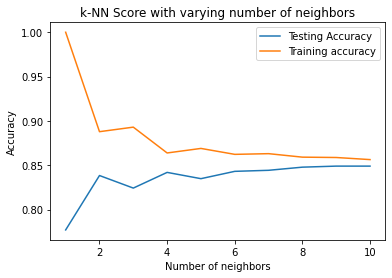

In [73]:
# Generate plot
plt.title('k-NN Score with varying number of neighbors')
x_axis = [i for i in range(1,11)]
plt.plot(x_axis, test_accuracy, label='Testing Accuracy')
plt.plot(x_axis, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

Webcan see that test score is increasing as number of neighbours increases.

Let's try to find best parameter for knn.

In [77]:
param_grid = {'n_neighbors':np.arange(1,50)}

In [79]:
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [80]:
knn_cv.best_score_

0.8513274336283185

In [81]:
knn_cv.best_params_

{'n_neighbors': 13}

Text(0.5, 1.0, 'Roc Auc Curve for kNN - 13')

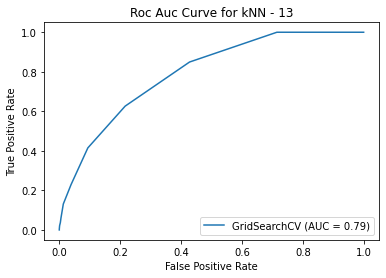

In [87]:
plot_roc_curve(knn_cv,X,Y)
plt.title("Roc Auc Curve for kNN - " + str(knn_cv.best_params_['n_neighbors']))

## **Naive Bayes Classifier** 

In [93]:
# build model and train it
naive_bayes_model = GaussianNB().fit(X_train,Y_train)

In [95]:
# predict values
train_preds = naive_bayes_model.predict(X_train)
test_preds = naive_bayes_model.predict(X_test)

In [96]:
print(confusion_matrix(Y_train, train_preds))
print(confusion_matrix(Y_test, test_preds))

[[2040  120]
 [ 303   79]]
[[669  50]
 [110  19]]


[[2149   11]
 [ 339   43]]


[Text(0, 0.5, 'At Risk'), Text(0, 1.5, 'No Risk')]

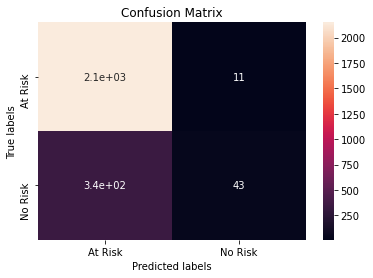

In [116]:
# Get the confusion matrix for train 
labels = ['At Risk', 'No Risk']
cm = confusion_matrix(Y_train, train_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

[[704  15]
 [119  10]]


[Text(0, 0.5, 'At Risk'), Text(0, 1.5, 'No Risk')]

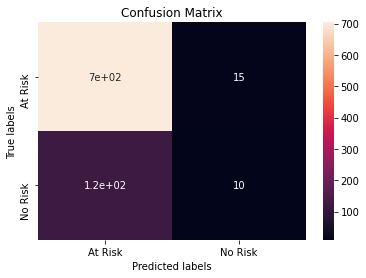

In [117]:
# Get the confusion matrix for test 
labels = ['At Risk', 'No Risk']
cm = confusion_matrix(Y_test, test_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [97]:
# Print the classification report for train and test
print(classification_report(Y_train, train_preds))
print("\n")
print(classification_report(Y_test, test_preds))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2160
           1       0.40      0.21      0.27       382

    accuracy                           0.83      2542
   macro avg       0.63      0.58      0.59      2542
weighted avg       0.80      0.83      0.81      2542



              precision    recall  f1-score   support

           0       0.86      0.93      0.89       719
           1       0.28      0.15      0.19       129

    accuracy                           0.81       848
   macro avg       0.57      0.54      0.54       848
weighted avg       0.77      0.81      0.79       848



# **Logistic Regression**

In [104]:
# create and train logistic regression model
logistic_regression_model = LogisticRegression(fit_intercept=True, max_iter=10000)
logistic_regression_model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
# Get the model coefficients
logistic_regression_model.coef_

array([[ 6.78713767e-02, -3.60638989e-02,  3.91125116e-01,
         3.55567513e-02,  2.99434131e-02,  4.57593361e-01,
         9.70818517e-01,  1.27887333e-01,  3.86592419e-02,
         1.35070475e-03,  1.87163689e-02, -9.67462014e-03,
        -4.57935282e-04, -9.12400058e-03,  9.65456985e-03]])

In [110]:
# Get the predicted probabilities
train_preds = logistic_regression_model.predict(X_train)
test_preds = logistic_regression_model.predict(X_test)

In [112]:
# Get the accuracy scores
train_accuracy = accuracy_score(train_preds,Y_train)
test_accuracy = accuracy_score(test_preds,Y_test)

print("The accuracy on train data is ", train_accuracy)
print("The accuracy on test data is ", test_accuracy)

The accuracy on train data is  0.8623131392604249
The accuracy on test data is  0.8419811320754716


[[2149   11]
 [ 339   43]]


[Text(0, 0.5, 'At Risk'), Text(0, 1.5, 'No Risk')]

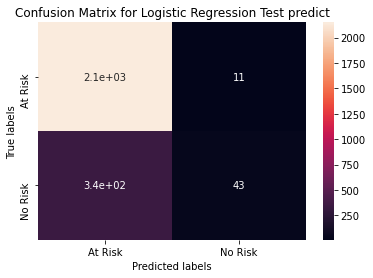

In [115]:
# Get the confusion matrix for train
labels = ['At Risk', 'No Risk']
cm = confusion_matrix(Y_train, train_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Logistic Regression Test predict')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

[[704  15]
 [119  10]]


[Text(0, 0.5, 'At Risk'), Text(0, 1.5, 'No Risk')]

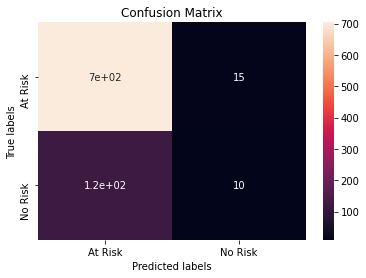

In [119]:
# Get the confusion matrix for test
labels = ['At Risk', 'No Risk']
cm = confusion_matrix(Y_test, test_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [120]:
# Print the classification report for train and test
print(classification_report(Y_train, train_preds))
print("\n")
print(classification_report(Y_test, test_preds))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2160
           1       0.80      0.11      0.20       382

    accuracy                           0.86      2542
   macro avg       0.83      0.55      0.56      2542
weighted avg       0.85      0.86      0.82      2542



              precision    recall  f1-score   support

           0       0.86      0.98      0.91       719
           1       0.40      0.08      0.13       129

    accuracy                           0.84       848
   macro avg       0.63      0.53      0.52       848
weighted avg       0.79      0.84      0.79       848



Text(0.5, 1.0, 'Roc Auc Curve for Logistic Regression')

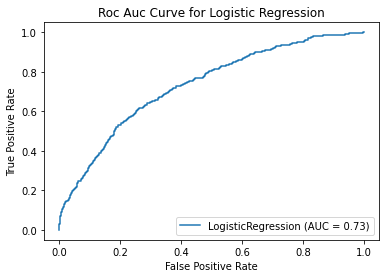

In [121]:
plot_roc_curve(logistic_regression_model,X,Y)
plt.title("Roc Auc Curve for Logistic Regression")